In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, Input
import matplotlib.pyplot as plt

In [2]:
address = r"IMU Dataset\Data"

learnRate = 1e-4
batchSize = 5
patience = 4
epoch = 200

window_stride = 10
sample_len = 100
static_sample = 3
features = 27
static_features = 3
volunteers = 30
train_portion = 0.8
val_portion = 0.9
classes = 5

trunk = 1
thighR = 2
thighL = 3
shankR = 4
shankL = 5
wrist = 6

headers = ['Acc_X', 'Acc_Y', 'Acc_Z', 
        'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
        'Roll', 'Pitch', 'Yaw']

norm = {'Acc_X': [-20.59292, 31.47302], 
        'Acc_Y': [-13.67152, 19.44969], 
        'Acc_Z': [-35.48537, 18.8095], 
        'Gyr_X': [-6.838557, 7.868352], 
        'Gyr_Y': [-16.90477, 16.61124], 
        'Gyr_Z': [-4.431263, 6.664771], 
        'Roll': [-207.2701, 214.6915], 
        'Pitch': [-89.953, 87.27671], 
        'Yaw': [-203.8373, 204.2526]}

In [3]:
def normalize_fixed(x, current_range, normed_range):
    current_min, current_max = current_range
    normed_min, normed_max = normed_range
    x_normed = (x - current_min) / (current_max - current_min)
    x_normed = x_normed * (normed_max - normed_min) + normed_min
    return x_normed

def trialLabel(num):
    if num in range(4, 10):
        return 0  # 'FE'
    if num in [16, 18, 20, 22, 24, 26]:
        return 1  # 'StrU'
    if num in [17, 19, 21, 23, 25, 27]:
        return 2  # 'StrD'
    if num in [28, 30, 32, 34, 36, 38]:
        return 3  # 'SlpU'
    if num in [29, 31, 33, 35, 37, 39]:
        return 4  # 'SlpD'
    print('Check dataset!')


def trialName(num):
    if num in range(4, 10):
        return 'FE: 0'
    if num in [16, 18, 20, 22, 24, 26]:
        return 'StrU: 1'
    if num in [17, 19, 21, 23, 25, 27]:
        return 'StrD: 2'
    if num in [28, 30, 32, 34, 36, 38]:
        return 'SlpU: 3'
    if num in [29, 31, 33, 35, 37, 39]:
        return 'SlpD: 4'
    return False


def trialInd(num):
    if num == 0:
        return 'FE: 0'
    if num == 1:
        return 'StrU: 1'
    if num == 2:
        return 'StrD: 2'
    if num == 3:
        return 'SlpU: 3'
    if num == 4:
        return 'SlpD: 4'
    return False


def openCSV(addr):
    df = pd.read_csv(addr, sep=',', header=None)
    header = df.iloc[0]
    df = pd.DataFrame(df[1:], dtype=float)
    df.columns = header
    return df

In [4]:
try:
    with open('Objects\\data', 'rb') as f:
        data = pickle.load(f)
    print("Loaded saved objects")
        
except:
    data = []
    for person in range(0, volunteers):
        tmp1 = []
        print(person + 1, "out of", volunteers)
        for trial in range(0, 57):
            tmp2 = []
            for sensor in range(0, 6):
                tmp2.append(openCSV(address + f"\\person{person + 1}_trial{trial + 1}_sensor{sensor + 1}.csv"))
            tmp1.append(tmp2)
        data.append(tmp1)

    with open("Objects\\data", 'ab') as f:
        pickle.dump(data, f)

Loaded saved objects


In [5]:
# dic = {'Acc_X': [1e10, -1e10], 'Acc_Y': [1e10, -1e10], 'Acc_Z': [1e10, -1e10],
#         'Gyr_X': [1e10, -1e10], 'Gyr_Y': [1e10, -1e10], 'Gyr_Z': [1e10, -1e10], 
#         'Roll': [1e10, -1e10], 'Pitch': [1e10, -1e10], 'Yaw': [1e10, -1e10]}

# for person in range(0, volunteers):
#     for trial in list(range(3, 9)) + list(range(15, 39)):
#         flag = False
#         for i in range(samplePerTrial):
#             for sample in range(i * sampleLen, sampleLen + i * sampleLen):
#                 for sensor in range(1, 5):
#                     if flag:
#                         break
#                     if len(data[person][trial][sensor]) < optLen:
#                         flag = True
#                         continue
#                     for para in ['Acc_X', 'Acc_Y', 'Acc_Z', 
#                                 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
#                                 'Roll', 'Pitch', 'Yaw']:
#                         if data[person][trial][sensor][para].values[sample] > dic[para][1]:
#                             dic[para][1] = data[person][trial][sensor][para].values[sample]
#                         elif data[person][trial][sensor][para].values[sample] < dic[para][0]:
#                             dic[para][0] = data[person][trial][sensor][para].values[sample]

# print(dic)

In [5]:
dic2 = {'AGE': [1e10, -1e10], 'HEIGHT': [1e10, -1e10], 'WEIGHT': [1e10, -1e10],
        'BMI': [1e10, -1e10], 'BMR': [1e10, -1e10], 'BSA': [1e10, -1e10]}
height_average = 169.3
height_sd = 21.5
weight_average = 70.9
weight_sd = 13.9
subjects = []

with open('subjects.txt') as f:
    for r in f:
        r = r.split()

        bmi = float(r[4]) / (float(r[3]) / 100) ** 2
        if r[2] == "M":
            bmr = 88.362 + (13.397 * float(r[4])) + (4.799 * float(r[3])) - (5.677 * float(r[1]))
        else:
            bmr = 447.593 + (9.247 * float(r[4])) + (3.098 * float(r[3])) - (4.330 * float(r[1]))
        bsa = float(r[3]) * float(r[4]) / 3600
        sigma_h = 1 if abs(float(r[3]) - height_average) <= height_sd else 0
        sigma_w = 1 if abs(float(r[4]) - weight_average) <= weight_sd else 0
        subjects.append([[float(r[1]), float(r[3]), float(r[4])], [bmi, bmr, bsa], [sigma_h, sigma_w, 1.0 if r[2] == 'F' else 0.0]])

        if float(r[1]) < dic2['AGE'][0]:
            dic2['AGE'][0] = float(r[1])
        if float(r[1]) > dic2['AGE'][1]:
            dic2['AGE'][1] = float(r[1])

        if float(r[3]) < dic2['HEIGHT'][0]:
            dic2['HEIGHT'][0] = float(r[3])
        if float(r[3]) > dic2['HEIGHT'][1]:
            dic2['HEIGHT'][1] = float(r[3])

        if float(r[4]) < dic2['WEIGHT'][0]:
            dic2['WEIGHT'][0] = float(r[4])
        if float(r[4]) > dic2['WEIGHT'][1]:
            dic2['WEIGHT'][1] = float(r[4])

        if bmi < dic2['BMI'][0]:
            dic2['BMI'][0] = bmi
        if bmi > dic2['BMI'][1]:
            dic2['BMI'][1] = bmi

        if bmr < dic2['BMR'][0]:
            dic2['BMR'][0] = bmr
        if bmr > dic2['BMR'][1]:
            dic2['BMR'][1] = bmr

        if bsa < dic2['BSA'][0]:
            dic2['BSA'][0] = bsa
        if bsa > dic2['BSA'][1]:
            dic2['BSA'][1] = bsa

for i in range(len(subjects)):
    subjects[i][0][0] = normalize_fixed(subjects[i][0][0], [dic2['AGE'][0], dic2['AGE'][1]], [-1, 1])
    subjects[i][0][1] = normalize_fixed(subjects[i][0][1], [dic2['HEIGHT'][0], dic2['HEIGHT'][1]], [-1, 1])
    subjects[i][0][2] = normalize_fixed(subjects[i][0][2], [dic2['WEIGHT'][0], dic2['WEIGHT'][1]], [-1, 1])
    subjects[i][1][0] = normalize_fixed(subjects[i][1][0], [dic2['BMI'][0], dic2['BMI'][1]], [-1, 1])
    subjects[i][1][1] = normalize_fixed(subjects[i][1][1], [dic2['BMR'][0], dic2['BMR'][1]], [-1, 1])
    subjects[i][1][2] = normalize_fixed(subjects[i][1][2], [dic2['BSA'][0], dic2['BSA'][1]], [-1, 1])

In [6]:
try:
    with open('Objects\\inputs_r', 'rb') as f:
        inputs = np.load(f)
    with open('Objects\\targets_r', 'rb') as f:
        targets = pickle.load(f)
    with open('Objects\\statics_r', 'rb') as f:
        statics = pickle.load(f)
    print("Loaded saved objects")
        
except:
    inputs = np.empty((300000, sample_len, features), dtype=float)
    targets = []
    statics = []
    counter = 0
    errors = 0

    for person in range(0, volunteers):
        print(person + 1, "out of", volunteers)
        for trial in list(range(3, 9)) + list(range(15, 39)):
            opt_len = min([len(data[person][trial][s]) for s in range(5)])
            for i in range(0, opt_len - sample_len, window_stride):
                for sample in range(i, i + sample_len):
                    for sensor in [0, 1, 3]:
                        for ind, para in enumerate(headers):
                            raw_data = data[person][trial][sensor][para].values[sample]
                            if not np.isfinite(raw_data):
                                raw_data = 0
                                errors += 1
                            norm_data = normalize_fixed(raw_data, norm[para], [-1, 1])
                            if sensor == 3:
                                inputs[counter][sample - i][ind + len(headers) * 2] = norm_data
                            else:
                                inputs[counter][sample - i][ind + len(headers) * sensor] = norm_data
                targets.append(int(trialLabel(trial + 1)))
                statics.append([subjects[person]])
                counter += 1

    print(errors)   

    inputs = inputs[:counter]
    with open("Objects\\inputs_r", 'ab') as f:
        np.save(f, inputs)
    with open("Objects\\targets_r", 'ab') as f:
        pickle.dump(targets, f)
    with open("Objects\\statics_r", 'ab') as f:
        pickle.dump(statics, f)

print(len(inputs))

1 out of 30
2 out of 30
3 out of 30
4 out of 30
5 out of 30
6 out of 30
7 out of 30
8 out of 30
9 out of 30
10 out of 30
11 out of 30
12 out of 30
13 out of 30
14 out of 30
15 out of 30
16 out of 30
17 out of 30
18 out of 30
19 out of 30
20 out of 30
21 out of 30
22 out of 30
23 out of 30
24 out of 30
25 out of 30
26 out of 30
27 out of 30
28 out of 30
29 out of 30
30 out of 30
0
300000


In [6]:
inputs2, statics2, targets2 = shuffle(inputs, statics, targets)

del inputs
del targets
del statics

statics2 = tf.convert_to_tensor(statics2)
targets2 = tf.one_hot(targets2, classes)

train = inputs2[:int(train_portion * len(inputs2))]
train_s = statics2[:int(train_portion * len(inputs2))]
train_label = targets2[:int(train_portion * len(inputs2))]

val = inputs2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]
val_s = statics2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]
val_label = targets2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]

test = inputs2[int(val_portion * len(inputs2)):]
test_s = statics2[int(val_portion * len(inputs2)):]
test_label = targets2[int(val_portion * len(inputs2)):]

del inputs2
del targets2
del statics2

print(test.shape, test_s.shape, test_label.shape)

(14141, 100, 27) (14141, 1, 4) (14141, 5)


Epoch 1/200
22626/22626 [==============================] - 293s 13ms/step - loss: 0.4118 - accuracy: 0.8508 - val_loss: 0.2704 - val_accuracy: 0.9006
Epoch 2/200
22626/22626 [==============================] - 286s 13ms/step - loss: 0.2220 - accuracy: 0.9241 - val_loss: 0.1813 - val_accuracy: 0.9356
Epoch 3/200
22626/22626 [==============================] - 270s 12ms/step - loss: 0.1641 - accuracy: 0.9454 - val_loss: 0.1401 - val_accuracy: 0.9527
Epoch 4/200
22626/22626 [==============================] - 282s 12ms/step - loss: 0.1318 - accuracy: 0.9565 - val_loss: 0.1149 - val_accuracy: 0.9604
Epoch 5/200
22626/22626 [==============================] - 283s 13ms/step - loss: 0.1113 - accuracy: 0.9636 - val_loss: 0.1023 - val_accuracy: 0.9658
Epoch 6/200
22626/22626 [==============================] - 266s 12ms/step - loss: 0.0971 - accuracy: 0.9676 - val_loss: 0.0921 - val_accuracy: 0.9681
Epoch 7/200
22626/22626 [==============================] - 284s 13ms/step - loss: 0.0861 - accuracy:

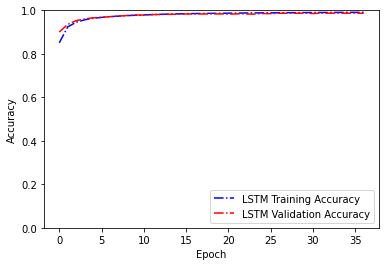

In [7]:
### LSTM + CNN
# try:
#     model_rnn = models.load_model('model')

# except Exception as e:
time_series_input = Input(shape=(sample_len, features))
static_input = Input(shape=(static_sample, static_features))

lstm = layers.LSTM(32, return_sequences=True)(time_series_input)
static1 = layers.Conv1D(32, 2, strides=1, activation=tf.nn.relu)(static_input)
static2 = layers.MaxPooling1D(pool_size=2, strides=1)(static1)

main = layers.Concatenate(axis= 1)([lstm, static2])
flat = layers.Flatten()(main)
out = layers.Dense(classes, activation='softmax')(flat)

model_rnn = models.Model(inputs=[time_series_input, static_input],
                            outputs=out)

model_rnn.compile(optimizer=optimizers.Adam(learning_rate=learnRate), 
                metrics=['accuracy'],
                loss=losses.CategoricalCrossentropy(from_logits=False))

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history_rnn = model_rnn.fit([train, train_s], train_label, batch_size=batchSize, epochs=epoch, 
                            validation_data=([val, val_s], val_label), callbacks=[earlyStop], shuffle=False)

plt.plot(history_rnn.history['accuracy'], 'b-.', label="LSTM Training Accuracy")
plt.plot(history_rnn.history['val_accuracy'], 'r-.', label="LSTM Validation Accuracy")
plt.plot(history_rnn.history['loss'], 'b.', label="LSTM Training Loss")
plt.plot(history_rnn.history['val_loss'], 'r.', label="LSTM Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='center right')
plt.show()

In [8]:
model_rnn.save('model_r')

with open("test2", 'ab') as f:
    pickle.dump(test, f)
with open("test_s2", 'ab') as f:
    pickle.dump(test_s, f)
with open("test_label2", 'ab') as f:
    pickle.dump(test_label, f)

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


In [9]:
# with open('test', 'rb') as f:
#     test = pickle.load(f)
# with open('test_s', 'rb') as f:
#     test_s = pickle.load(f)
# with open('test_label', 'rb') as f:
#     test_label = pickle.load(f)

print(f"Test Accuracy LSTM: {model_rnn.evaluate([test, test_s], test_label)[1] * 100:.2f}%")

442/442 [==============================] - 4s 8ms/step - loss: 0.0364 - accuracy: 0.9873
Test Accuracy LSTM: 98.73%
